<a href="https://colab.research.google.com/github/OneRenix/GoBeyondColab/blob/main/RAGS_AI_STUDY_RENZI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple RAG Application for AI Study Group:

**This code demonstrates the Retrieval-Augmented Generation (RAG) process:**

1. It creates a small document.
2. It uses a special AI model from Google to understand the meaning of the document and store it in a database (ChromaDB).
3. When you ask a question, it uses the same AI model to understand the meaning of your question.
4. It searches the database for the most relevant information related to your question.
5. It then takes your original question and the relevant information it found and gives it to another AI model (Gemini) to generate a comprehensive answer.


**This approach helps language models provide more accurate and up-to-date answers by grounding them in specific knowledge sources.**

---


**Prerequisites:**
1. Google Account
2. Create a Google Gemini API Key in AI Studio: https://aistudio.google.com/app/apikey
3. If an error is encountered, setup your GCP Console account here: https://console.cloud.google.com/
4. Add your API Key in the Notebook under Secrets. Enable Notebook Access

# **Install necessary libraries using pip (package installer for Python):**

*   **langchain-google-genai**: Integrates Langchain with Google's generative AI models.
*   **google-generativeai**: Google's official library for interacting with their AI models.
*   **chromadb**: A database for storing and searching embeddings (numerical representations of text)
*   **langchain-community**: Contains integrations and tools for the Langchain framework.

In [1]:
!pip install langchain-google-genai google-generativeai
!pip install chromadb
!pip install langchain-community
!pip install --upgrade google-generativeai
!pip install google-genai

Import necessary modules and classes

In [2]:
# For loading text documents
from langchain.document_loaders import TextLoader

# For interacting with Google Colab features
from google.colab import userdata

# For interacting with Google's generative AI models
from google import genai
from google.genai import types

# For displaying formatted text (like Markdown) in the output
from IPython.display import Markdown

Create a text file named "sample_document.txt" and write some content into it.

In [3]:
with open("sample_document.txt", "w") as f:
  f.write(
    """The main topic of this document is the importance of incorporating retrieval mechanisms into large language models (LLMs) to improve their accuracy and ability to provide up-to-date information. This technique, known as Retrieval-Augmented Generation (RAG), allows LLMs to access external knowledge sources at the time of answering a question. This helps to mitigate the issue of LLM hallucinations and provides more grounded and reliable responses."""
  )

Configure Google Generative AI

In [4]:
# Ensure you have stored your API key in Colab under the name 'GOOGLE_API_KEY'.
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# Create a client object to interact with the Google Generative AI models.
client = genai.Client(api_key=GOOGLE_API_KEY)

List available models and print the names of those that support content embedding. Embedding models can convert text into numerical vectors that capture their meaning.

In [5]:
print("\nAvailable embedding models:")
for model in client.models.list():
    if "embedContent" in model.supported_actions:
        print(f"- {model.name}")


Available embedding models:
- models/embedding-001
- models/text-embedding-004
- models/gemini-embedding-exp-03-07
- models/gemini-embedding-exp


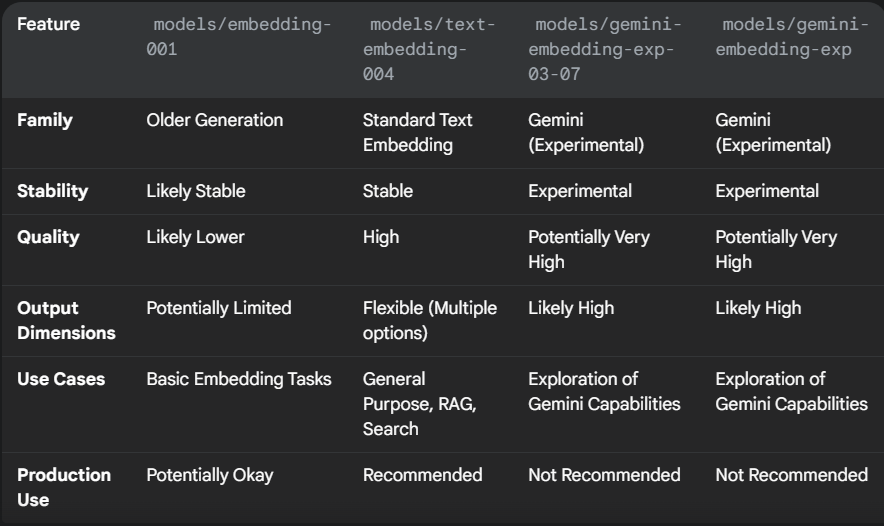

Set up ChromaDB for storing and retrieving document embeddings

In [6]:
# Import necessary classes from the chromadb library.
from chromadb import Documents, EmbeddingFunction, Embeddings, Client as ChromaClient

# Import the retry utility from Google API core for handling potential API rate limits.
from google.api_core import retry

Define a helper function to determine if an API error is retriable.


In [7]:
#This checks for specific error codes (429: Too Many Requests, 503: Service Unavailable).
def is_retriable(exception: Exception) -> bool:
    return isinstance(exception, genai.errors.APIError) and exception.code in {429, 503}

Generates embeddings for a list of input texts using the Gemini model.

In [8]:
# Define a custom embedding function using Google's Gemini model.
class GeminiEmbeddingFunction(EmbeddingFunction):
    """
    A custom embedding function that uses Google's Gemini model to create embeddings.
    """

    # Specify whether to generate embeddings for documents or queries.
    # True for embedding documents, False for embedding queries.
    document_mode = True

    # Use the retry decorator to automatically retry the embedding call if it fails with a retriable error.
    @retry.Retry(predicate=is_retriable)
    def __call__(self, input_texts: Documents) -> Embeddings:
        """
        Generates embeddings for a list of input texts using the Gemini model.

        Args:
            input_texts: A list of strings (documents or queries).

        Returns:
            A list of embeddings (numerical vectors).
        """
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        model_name = "models/text-embedding-004"  # Specify the Gemini embedding model to use

        response = client.models.embed_content(
            model=model_name,
            contents=input_texts,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [embedding.values for embedding in response.embeddings]

Load the sample document and create embeddings

In [9]:
# Create an instance of the TextLoader to load the content of the sample document.
loader = TextLoader("sample_document.txt")
documents = loader.load()
print("\nLoaded documents:")
print(documents)


Loaded documents:
[Document(metadata={'source': 'sample_document.txt'}, page_content='The main topic of this document is the importance of incorporating retrieval mechanisms into large language models (LLMs) to improve their accuracy and ability to provide up-to-date information. This technique, known as Retrieval-Augmented Generation (RAG), allows LLMs to access external knowledge sources at the time of answering a question. This helps to mitigate the issue of LLM hallucinations and provides more grounded and reliable responses.')]


Initialize ChromaDB

In [10]:
import chromadb
# Define the name for your ChromaDB collection.
DB_NAME = "DB_RAGS_STUDY"

# Create an instance of the custom Gemini embedding function.
embed_fn = GeminiEmbeddingFunction()
# Set the mode to document embedding as we are embedding our document.
embed_fn.document_mode = True

# Initialize the ChromaDB client.
chroma_client = chromadb.Client()


<ipython-input-10-4cd026072012>:6: DeprecationWarning: The class GeminiEmbeddingFunction does not implement __init__. This will be required in a future version.
  embed_fn = GeminiEmbeddingFunction()


Get or create a ChromaDB collection with the specified name and embedding function.

In [11]:
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

Extract text content and metadata from the loaded documents.

In [12]:
texts = [doc.page_content for doc in documents]
metadatas = [doc.metadata for doc in documents]
# Generate unique IDs for each document.
ids = [f"doc_{i}" for i in range(len(documents))]

Add the documents (along with their embeddings generated by Gemini) to the Chroma database.

In [13]:
# Add the documents to the Chroma database
db.add(
    documents=texts,
    metadatas=metadatas,
    ids=ids
)

In [14]:
print(f"\nSuccessfully added {db.count()} documents to the Chroma database '{DB_NAME}'.")


Successfully added 1 documents to the Chroma database 'DB_RAGS_STUDY'.


In [15]:
# Peek at the first document in the database.
print("\nFirst document in ChromaDB:")
print(db.peek(1))


First document in ChromaDB:
{'ids': ['doc_0'], 'embeddings': array([[-1.86554063e-02, -1.62896700e-02, -4.62222472e-02,
        -4.53758053e-03, -2.24068332e-02,  4.93324213e-02,
         5.23511171e-02,  9.61183570e-03,  1.96905360e-02,
        -2.17311867e-02, -4.21531200e-02, -2.01586448e-02,
         1.86433922e-02,  4.97282408e-02, -1.47368154e-02,
        -6.73633888e-02,  2.69820113e-02,  3.30568776e-02,
        -9.75081399e-02,  1.63301043e-02,  5.08912988e-02,
        -4.81878407e-03, -3.74729820e-02, -8.58033895e-02,
         8.28337763e-03,  1.00733424e-02,  7.34359324e-02,
         3.34843658e-02, -1.84799135e-02, -1.80099029e-02,
         3.70334387e-02,  3.13867144e-02,  3.54910307e-02,
        -2.82912385e-02, -2.22430024e-02,  3.16597037e-02,
         1.55155119e-02,  1.19550945e-02,  5.66228153e-03,
        -9.05678794e-02, -3.45838517e-02,  2.40887962e-02,
        -1.83241291e-03,  3.82712819e-02, -5.19264638e-02,
         2.27129161e-02,  4.16369848e-02,  9.97208133

In [16]:
# Print the total number of documents in the database.
print(f"\nNumber of documents in ChromaDB: {db.count()}")


Number of documents in ChromaDB: 1


Search the ChromaDB database

In [17]:
#The line embed_fn.document_mode = False sets a flag within your custom embedding function (GeminiEmbeddingFunction)
#to indicate that you are now going to generate embeddings for a search query rather than for a document.

embed_fn.document_mode = False

In [18]:
# Define the search query.
query = "What does RAG means?"

# Search the ChromaDB database using the query.
# ChromaDB will automatically embed the query using the same embedding function
# and find the most similar documents.
result = db.query(query_texts=[query], n_results=1)
# Extract the text content of the top matching document.
[all_passages] = result["documents"]

print("\nRetrieved passage from ChromaDB:")
# Display the retrieved passage using Markdown for better formatting.
Markdown(all_passages[0])


Retrieved passage from ChromaDB:


The main topic of this document is the importance of incorporating retrieval mechanisms into large language models (LLMs) to improve their accuracy and ability to provide up-to-date information. This technique, known as Retrieval-Augmented Generation (RAG), allows LLMs to access external knowledge sources at the time of answering a question. This helps to mitigate the issue of LLM hallucinations and provides more grounded and reliable responses.

Generate an answer using the Gemini language model

In [22]:
query_oneline = query.replace("\n", " ")

# This prompt is where you can specify any guidance on tone, or what topics the model should stick to, or avoid.
prompt = f"""You are a helpful and informative bot that answers questions using text from the reference passage included below.
Be sure to respond in a complete sentence, being comprehensive, including all relevant background information.
However, you are talking to a non-technical audience, so be sure to break down complicated concepts and
strike a friendly and converstional tone. If the passage is irrelevant to the answer, you may ignore it.

QUESTION: {query_oneline}
"""

# Add the retrieved documents to the prompt.
for passage in all_passages:
    passage_oneline = passage.replace("\n", " ")
    prompt += f"PASSAGE: {passage_oneline}\n"

print(prompt)

# Generate content using the Gemini Pro model with the constructed prompt.
# Access the models object through the client object
answer = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt)

print("\nAnswer:")
# Display the generated answer using Markdown for better formatting.
Markdown(answer.text)

You are a helpful and informative bot that answers questions using text from the reference passage included below.
Be sure to respond in a complete sentence, being comprehensive, including all relevant background information.
However, you are talking to a non-technical audience, so be sure to break down complicated concepts and
strike a friendly and converstional tone. If the passage is irrelevant to the answer, you may ignore it.

QUESTION: What does RAG means?
PASSAGE: The main topic of this document is the importance of incorporating retrieval mechanisms into large language models (LLMs) to improve their accuracy and ability to provide up-to-date information. This technique, known as Retrieval-Augmented Generation (RAG), allows LLMs to access external knowledge sources at the time of answering a question. This helps to mitigate the issue of LLM hallucinations and provides more grounded and reliable responses.


Answer:


Okay, so Retrieval-Augmented Generation, or RAG for short, is a way to make large language models better by allowing them to grab information from outside sources when they're answering a question. This helps the models be more accurate and up-to-date, and also reduces the chances of them making stuff up.


**gemini-2.0-flash**: This model is typically designed to be more cost-effective and optimized for speed. It's often suitable for tasks where low latency and high throughput are important, and where the complexity of the reasoning might be slightly lower. You can likely expect it to be priced lower per 1,000 characters or tokens compared to gemini-pro.

**gemini-pro**: This model is usually positioned as a more capable and powerful model, capable of handling more complex reasoning, understanding, and generation tasks. As a result of its enhanced capabilities, it typically comes with a higher cost per 1,000 characters or tokens compared to the "flash" variant.

For a much more challenging example of RAGS: https://www.kaggle.com/code/anurags397/pkmn-ask-em-all-rag-guide